<a href="https://colab.research.google.com/github/sonudoo/DSA/blob/master/Machine%20Learning/FixedLengthLSTMUsingTensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt

In [0]:
# We will be calculating the average of last 4 numbers in the series data using LSTM network

n_states = 10 # Number of states in the network. Let the LSTM see last 10 data. Also length of each training example.
n_input = 1 # Number of units in input layer
n_hidden = 5 # Number of units in hidden layer
n_output = 1 # Number of units in output layer
m = 1000 # Number of data points. Also, total length of the series
X_raw = np.random.uniform(low=0.0, high=1.0, size=m) # Generate 'm' random samples
time = np.arange(m)
batch_size = 10 # We will feed 'batch_size' training example (i.e 'batch_size' series of X and corresponding Y) at a time in each epoch
num_batches = (m + batch_size - 1) // batch_size // n_states

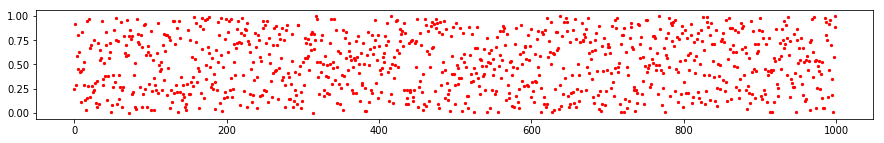

In [0]:
plt.figure(figsize=(15, 2))
plt.scatter(time, X_raw, alpha=1, color='r', s=5)
plt.show()

In [0]:
X_train = []
Y_train = []

# We divide the raw data points to m//n_states training example. Each example is a series of X and corresponding Y
# Each example has a length of n_states (fixed) 
# The output of each example is again a series. First 3 element of the series is zero and the rest are mean of last 4 elements.

for i in range(m // n_states):
    X_train.append(X_raw[i * n_states: (i + 1) * n_states])
    Y_train.append(np.array([0.0 for j in range(3)] + [np.mean(X_train[i][j-3: j+1]) for j in range(3, n_states)]))

X_train = np.array(X_train)
Y_train = np.array(Y_train)

In [0]:
# None represents number of training example in one shot (batch size), length of RNN state
# Since number of features is 1, we skip the third dimension, else it would have been added
X = tf.placeholder(dtype=tf.float32, shape=(batch_size, n_states))
Y = tf.placeholder(dtype=tf.float32, shape=(batch_size, n_states))

# Hidden layer

W_c = tf.Variable(tf.random_normal([n_hidden + n_input, n_hidden]))
W_u = tf.Variable(tf.random_normal([n_hidden + n_input, n_hidden]))
W_f = tf.Variable(tf.random_normal([n_hidden + n_input, n_hidden]))
W_o = tf.Variable(tf.random_normal([n_hidden + n_input, n_hidden]))

b_c = tf.Variable(tf.random_normal([1, n_hidden]))
b_u = tf.Variable(tf.random_normal([1, n_hidden]))
b_f = tf.Variable(tf.random_normal([1, n_hidden]))
b_o = tf.Variable(tf.random_normal([1, n_hidden]))

# Output layer

W_y = tf.Variable(tf.random_normal([n_hidden, n_output]))
b_y = tf.Variable(tf.random_normal([1, n_output]))

# We have to maintain a separate state for each example in the batch.

a = tf.zeros(dtype=tf.float32, shape=[batch_size, n_hidden]) 
c = tf.zeros(dtype=tf.float32, shape=[batch_size, n_hidden])

In [0]:
all_states_input = tf.unstack(X, axis=1) # Returns a list of tensors sliced column wise from X
all_states_label = tf.unstack(Y, axis=1) # Returns a list of tensors sliced column wise from X
total_loss = tf.constant(0.0)
Y_output = None

for ith_state in range(n_states):
    
    # We extract the ith state input and label
    X_state_input = tf.reshape(all_states_input[ith_state], shape=[batch_size, n_input])
    Y_state_label = tf.reshape(all_states_label[ith_state], shape=[batch_size, n_input])
    
    # Stack it with the previous state
    a_prev_x_stacked = tf.concat([a, X_state_input], 1)
    
    # Forward prop
    _c = tf.nn.tanh(tf.math.add(tf.matmul(a_prev_x_stacked, W_c), b_c))
    g_u = tf.nn.sigmoid(tf.math.add(tf.matmul(a_prev_x_stacked, W_u), b_u))
    g_f = tf.nn.sigmoid(tf.math.add(tf.matmul(a_prev_x_stacked, W_f), b_f))
    g_o = tf.nn.sigmoid(tf.math.add(tf.matmul(a_prev_x_stacked, W_o), b_o))
    c = tf.math.add(tf.math.multiply(g_u, _c), tf.math.multiply(g_f, c))
    a = tf.math.multiply(g_o, tf.nn.tanh(c))
    Y_state_output = tf.nn.sigmoid(tf.math.add(tf.matmul(a, W_y), b_y))
    if ith_state != 0:
        Y_output = tf.concat([Y_output, Y_state_output], axis=1)
    else:
        Y_output = Y_state_output
    
    # Calculate the loss for this state
    loss = tf.reduce_mean(tf.abs(tf.subtract(Y_state_label, Y_state_output)))
    
    # Add it to total loss. Total loss is the loss on all the states
    total_loss = tf.add(total_loss, loss)

optimizer = tf.train.AdamOptimizer(0.01).minimize(total_loss)


In [0]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

In [0]:
for epoch in range(100):
    loss_across_batches = []
    for i in range(num_batches):
        X_train_batch = np.array(X_train[i * batch_size: (i + 1) * batch_size])
        Y_train_batch = np.array(Y_train[i * batch_size: (i + 1) * batch_size])
        loss = sess.run([optimizer, total_loss], feed_dict={X: X_train_batch, Y: Y_train_batch})[1]
        loss_across_batches.append(loss)
    if epoch % 10 == 0:
        print(np.mean(np.array(loss_across_batches)))

2.8062482
0.7778994
0.37010157
0.26962858
0.23940082
0.21925664
0.2100728
0.2039465
0.19378452
0.18913902


In [0]:
X_test_raw = np.random.uniform(low=0.0, high=1.0, size=batch_size * n_states)

In [0]:
X_test = []
Y_test = []

for i in range(batch_size):
    X_test.append(X_test_raw[i * n_states: (i + 1) * n_states])
    Y_test.append(np.array([0.0 for j in range(3)] + [np.mean(X_test[i][j-3: j+1]) for j in range(3, n_states)]))

X_test = np.array(X_test)
Y_test= np.array(Y_test)

In [0]:
Y_pred = sess.run(Y_output, feed_dict={X: X_test})

In [0]:
print(X_test[0])
print(Y_test[0])
print(Y_pred[0])
print(np.mean(np.sum(np.abs(Y_test - Y_pred), axis=1)))

[0.472836   0.33658409 0.73802215 0.32932288 0.86545649 0.05890311
 0.12850533 0.01925731 0.22013189 0.91082657]
[0.         0.         0.         0.46919128 0.5673464  0.49792616
 0.34554695 0.26803056 0.10669941 0.31968028]
[1.5277267e-03 1.4284253e-04 4.5517981e-03 4.9825555e-01 6.0322237e-01
 4.7484466e-01 3.5684544e-01 2.3547712e-01 1.9089597e-01 3.2835948e-01]
0.19719259505735667


In [0]:
# Note that we have output very close to the actual output. 
# The first three numbers are close to zero and starting from fourth number the output is close to mean value